# Biodiversity Intactness Index change in Phoenix, AZ 

### Author: Kimberlee Wong
### Link to [Repository](https://github.com/kimberleewong/eds220-biodiversity-intactness)

## About

### Purpose
The following analysis was done in two-fold. Its purpose is to get a better understanding of the 2017 Thomas Fire that affected Ventura and Santa Barbara Counties. The first part shows the process of producing a graph that shows how the average air quality was affected, and the second part visualizes the region of fire through a false imagery map. 

### Highlights

- Using rioxr to import the landsat data and access its attribute
- Visualizing both true and false color images
- Combining two different datasets to make one map

### About the Data

The biodiversity intactness data comes from Microsoft Planetary Computer Data Catalogue.

The Thomas Fire boundary was created in the previous notebook by filtering a California Fire perimeter file available from the US Government Data Catalogue.

### References

Microsoft Planetary Computer Data Catalogue, Biodiversity Intactness. Available from: https://planetarycomputer.microsoft.com/dataset/io-biodiversity Access date: December 7, 2024.

United States Census Bureau. 2020 version. Available from: https://www.census.gov/cgi-bin/geo/shapefiles/index.php Access date: December 7, 2024

## Import Libraries and Load Data

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import rioxarray as rioxr
import contextily as ctx
from shapely.geometry import box  # To create polygon bounding box

from pystac_client import Client  # To access STAC catalogs

import planetary_computer  # To sign items from the MPC STAC catalog 

from IPython.display import Image  # To nicely display images

pd.set_option("display.max.columns", None) # To see all columns

arizona = gpd.read_file(os.path.join('data', 'tl_2020_04_cousub','tl_2020_04_cousub.shp'))

## Exploration of Arizona Shapefile

<Axes: >

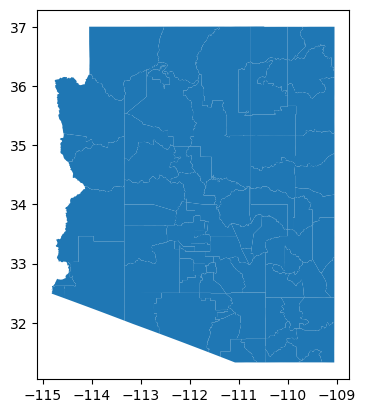

In [2]:
# Visualize Arizona
arizona.plot()

In [3]:
# Look at first three rows
arizona.head(3)

,STATEFP,COUNTYFP,COUSUBFP,COUSUBNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CNECTAFP,NECTAFP,NCTADVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,04,015,91964,02582914,0401591964,Lake Havasu City,Lake Havasu City CCD,22,Z5,G4040,None,None,None,S,7493863105,50863803,+34.7686221,-113.8749805,"POLYGON ((-114.48778 34.71722, -114.48622 34.7..."
1,04,007,91277,02582913,0400791277,Fort Apache,Fort Apache CCD,22,Z5,G4040,None,None,None,S,2134058292,4388167,+33.8847663,-110.3394452,"POLYGON ((-110.78327 34.16750, -110.78276 34.1..."
2,04,003,90306,01934923,0400390306,Bisbee,Bisbee CCD,22,Z5,G4040,None,None,None,S,1610943633,3494169,+31.4580397,-110.0783372,"POLYGON ((-110.46089 31.47376, -110.46089 31.4..."


In [4]:
print('CRS: ', arizona.crs)

print(f"ellipsoid: {arizona.crs.ellipsoid}")

print(f"datum: {arizona.crs.datum}")

# Set the label width to 25 characters, aligning the answers
print(f"{'Is the CRS geographic?:':<25} {arizona.crs.is_geographic}")
print(f"{'Is the CRS projected?:':<25} {arizona.crs.is_projected}")

CRS:  EPSG:4269
ellipsoid: GRS 1980
datum: North American Datum 1983
Is the CRS geographic?:   True
Is the CRS projected?:    False


After initial exploration of the Arizona shapefile, we can see that its CRS is EPSG:4269 and geographic. This is important to note for visualization purposes, so CRSs can match up. Because we need a Phoenix boundary, we can use the 'NAME' column as seen in the head of the geodataframe to filter our original data. 

In [5]:
# Create Phoenix shapefile by filtering arizona
phoenix_shp = arizona[arizona['NAME'] == 'Phoenix']
phoenix_shp

,STATEFP,COUNTYFP,COUSUBFP,COUSUBNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CNECTAFP,NECTAFP,NCTADVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
46,04,013,92601,01934968,0401392601,Phoenix,Phoenix CCD,22,Z5,G4040,None,None,None,S,2805901266,10048820,+33.5211331,-112.0284405,"POLYGON ((-112.47014 33.55996, -112.47011 33.5..."


<Axes: >

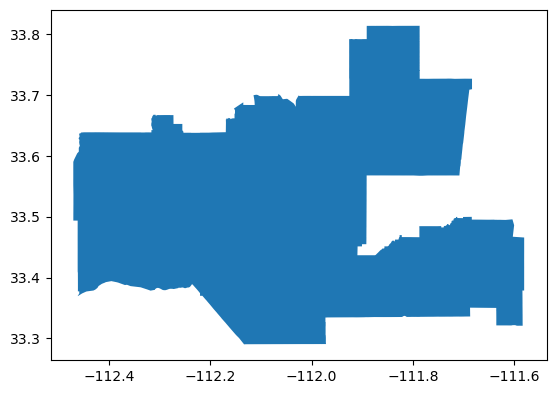

In [6]:
# Plot the new shapefile to make sure it looks correct
phoenix_shp.plot()

## Exploration of Microsoft Planetary Catalog

### Access

In [7]:
# Biodiversity Intactness Index (BII) Time Series Collection #

# Access MPC catalog
catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

### Explore catalog metadata

In [8]:
print('Title:', catalog.title)
print('Description:', catalog.description)

Title: Microsoft Planetary Computer STAC API
Description: Searchable spatiotemporal metadata describing Earth science datasets hosted by the Microsoft Planetary Computer


In [9]:
# Get collections and print their names
collections = list(catalog.get_collections())  # Turn generator into list

print('Number of collections:', len(collections))

print("Collections IDs (first 10):")
for i in range(10):
    print('-', collections[i].id)

Number of collections: 124
Collections IDs (first 10):
- daymet-annual-pr
- daymet-daily-hi
- 3dep-seamless
- 3dep-lidar-dsm
- fia
- sentinel-1-rtc
- gridmet
- daymet-annual-na
- daymet-monthly-na
- daymet-annual-hi


After accessing the catalog, we found the title and its description. We also found that there are a total of 124 collections, and printed out the first ten. Now, we can look at the specific collection we want with our desired bounding box and time range.

## Access Biodiversity Intactness Index

In [10]:
# Access the specific 'io_biodiversity' collection #

# Temporal range of interest
time_range = "2017-01-01/2023-01-01"

# Set bounding box given
bbox = {
    "type": "Polygon",
    "coordinates":[
        [
            [-112.826843, 33.863574],
            [-112.826843, 32.974108],
            [-111.184387, 32.974108],
            [-111.184387, 33.863574],
            [-112.826843, 33.863574]
        ]
    ],
}

# Catalog search
search = catalog.search(
    collections = ['io-biodiversity'],
    intersects = bbox,
    datetime = time_range)
search

In [11]:
# Retrieve search items
items = search.item_collection()
len(items)

4

In [12]:
items

By viewing items, we can see the search matched how many items there are -- 4.

In [16]:
# Select the items we want for years 2020 and 2017
item_2020 = items[0]

item_2017 = items[3]

In [19]:
# Print item_2017 ID and properties
print('ID:' , item_2017.id)
item_2017.properties

ID: bii_2017_34.74464974521749_-115.38597824385106_cog


{'datetime': None,
 'proj:epsg': 4326,
 'proj:shape': [7992, 7992],
 'end_datetime': '2017-12-31T23:59:59Z',
 'proj:transform': [0.0008983152841195215,
  0.0,
  -115.38597824385106,
  0.0,
  -0.0008983152841195215,
  34.74464974521749,
  0.0,
  0.0,
  1.0],
 'start_datetime': '2017-01-01T00:00:00Z'}

In [20]:
# Print item_2017 ID and properties
print('ID:' , item_2020.id)
item_2020.properties

ID: bii_2020_34.74464974521749_-115.38597824385106_cog


{'datetime': None,
 'proj:epsg': 4326,
 'proj:shape': [7992, 7992],
 'end_datetime': '2020-12-31T23:59:59Z',
 'proj:transform': [0.0008983152841195215,
  0.0,
  -115.38597824385106,
  0.0,
  -0.0008983152841195215,
  34.74464974521749,
  0.0,
  0.0,
  1.0],
 'start_datetime': '2020-01-01T00:00:00Z'}

In [21]:
# Print each asset key
for key in item_2017.assets.keys():
    print(key, '--', item_2017.assets[key].title)

data -- Biodiversity Intactness
tilejson -- TileJSON with default rendering
rendered_preview -- Rendered preview


In [23]:
# Plot rendered preview of 2017
Image(url=item_2017.assets['rendered_preview'].href, width=500)

In [24]:
# Open the raster data from our 2017 and 2020 items
phoenix_2017 = rioxr.open_rasterio(item_2017.assets['data'].href)
phoenix_2020 = rioxr.open_rasterio(item_2020.assets['data'].href)

## Visualize Phoenix and its greater context

In [ ]:
# Plot Phoenix on top of a basemap for contextualization. # 

# Initialize figure
fig, ax = plt.subplots()

# Remove the axis for a cleaner map
ax.axis('off')

# Plot Phoenix boundary
phoenix_shp.boundary.plot(ax=ax, color = 'black')

# Plot Phoenix fill
phoenix_shp.plot(ax=ax, 
                color='orange',
                alpha=0.25)

# Add a basemap with a specified CRS to match Phoenix
ctx.add_basemap(ax, crs = phoenix_shp.crs)  

# Set title and axes labels
ax.set_title('Phoenix Subdivision in Arizona',
            fontsize=14)

plt.show()